In [95]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression

%matplotlib inline

# Задание 1

Подобрать таблицу данных с несбалансированными классами. Решить задачу классификации любым подходящим методом.

In [55]:
df = pd.read_csv('../mushrooms.csv')

counts = df['class'].value_counts()
p_counts, e_counts = counts

counts

e    4208
p    3916
Name: class, dtype: int64

In [56]:
p_indices = df[df['class'] == 'p'].index

new_p_percent = 0.4

drop_p_count = int(p_counts * (1.0 - new_p_percent))

mask = np.random.choice(p_indices, drop_p_count, replace=False)
mask.sort()

df_disb = df.drop(mask, axis=0)

df_disb['class'].value_counts()

e    4208
p    1392
Name: class, dtype: int64

In [57]:
df_disb.head()

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,p,x,s,n,t,p,f,c,n,k,...,s,w,w,p,w,o,p,k,s,u
1,e,x,s,y,t,a,f,c,b,k,...,s,w,w,p,w,o,p,n,n,g
2,e,b,s,w,t,l,f,c,b,n,...,s,w,w,p,w,o,p,n,n,m
4,e,x,s,g,f,n,f,w,b,k,...,s,w,w,p,w,o,e,n,a,g
5,e,x,y,y,t,a,f,c,b,n,...,s,w,w,p,w,o,p,k,n,g


In [77]:
df_enc = df_disb.transform(lambda x: LabelEncoder().fit_transform(x))
df_enc.head()

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,1,5,2,4,1,6,1,0,1,4,...,2,7,7,0,2,1,4,2,3,5
1,0,5,2,9,1,0,1,0,0,4,...,2,7,7,0,2,1,4,3,2,1
2,0,0,2,8,1,3,1,0,0,5,...,2,7,7,0,2,1,4,3,2,3
4,0,5,2,3,0,5,1,1,0,4,...,2,7,7,0,2,1,0,3,0,1
5,0,5,3,9,1,0,1,0,0,5,...,2,7,7,0,2,1,4,2,2,1


In [78]:
X = df_enc.drop(['class'], axis=1)
y = df_enc['class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [107]:
logreg = LogisticRegression(solver='newton-cg')

logreg.fit(X_train, y_train)
y_probs = logreg.predict_proba(X_test)[:, 1]

print('Accuracy: ', logreg.score(X_test, y_test))

Accuracy:  0.9369047619047619


# Задание 2

 Вычислить точность, полноту, специфичность.

In [105]:

def metrics(y_pred: np.ndarray, y_gt: np.ndarray):
  return {
    'TP': np.count_nonzero(np.logical_and(y_pred == 1, y_gt == 1)),
    'TN': np.count_nonzero(np.logical_and(y_pred == 0, y_gt == 0)),
    'FP': np.count_nonzero(np.logical_and(y_pred == 1, y_gt == 0)),
    'FN': np.count_nonzero(np.logical_and(y_pred == 0, y_gt == 1))
  }

def true_pos_rate(metrics):
  '''
  Recall or TPR
  '''
  return metrics['TP'] / (metrics['TP'] + metrics['FN'])

def false_pos_rate(metrics):
  return metrics['FP'] / (metrics['TN'] + metrics['FP'])

def precision(metrics):
  return metrics['TP'] / (metrics['TP'] + metrics['FP'])

def specificity(metrics):
  return metrics['TN'] / (metrics['TN'] + metrics['FP'])

def _get_curve_impl(y_prob: np.ndarray, y_ground_truth: np.ndarray, thresholds: np.ndarray, x_func, y_func):
   x = np.zeros_like(thresholds)
   y = np.zeros_like(thresholds)
   for i, threshold in enumerate(sorted(thresholds, reverse=True)):
       y_predict = y_prob >= threshold
       met = metrics(y_predict, y_ground_truth)
       x[i] = x_func(met)
       y[i] = y_func(met)
   return x, y

def get_roc_curve(y_prob: np.ndarray, y_ground_truth: np.ndarray):
  '''
  returns: FPR, TPR
  '''
  thresholds = np.concatenate(([0.], y_prob, [1.]))
  return _get_curve_impl(y_prob, y_ground_truth, thresholds, false_pos_rate, true_pos_rate)


def get_pr_curve(y_prob: np.ndarray, y_ground_truth: np.ndarray):
  '''
  returns: recall, precision
  '''
  rec, pre = _get_curve_impl(y_prob, y_ground_truth, y_prob, true_pos_rate, precision)
  return np.concatenate(([0.], rec)), np.concatenate(([1.], pre))


def auc(x_vals, y_vals):
  return np.trapz(y_vals, x_vals)


In [94]:
y_pred = logreg.predict(X_test)
test_metrics = metrics(y_pred, y_test)
print(*map(lambda t: f'{t[0]} = {t[1]}', test_metrics.items()), sep='\n')

TP = 355
TN = 1219
FP = 36
FN = 70


In [87]:
pattern = '{0} = {1:.2f} %'
print(pattern.format('Recall', true_pos_rate(test_metrics) * 100))
print(pattern.format('Precision', precision(test_metrics) * 100))
print(pattern.format('Specificity', specificity(test_metrics) * 100))

Recall = 83.53 %
Precision = 90.79 %
Specificity = 97.13 %


# Задание 3

Построить кривую ошибок и найти площадь под ней. Построить для сравнения кривую 'точность-полнота'.

In [116]:
def plot_curve(x, y, x_label, y_label, title):
  plt.figure(figsize=(10, 6), dpi=100)
  plt.title(title)
  plt.plot([0, 1], [0, 1], alpha = 0.3, color = 'black')
  plt.plot(x, y, 'b')
  plt.xlim([-0.05, 1.05])
  plt.ylim([-0.05, 1.05])
  plt.ylabel(y_label)
  plt.xlabel(x_label)
  plt.grid()

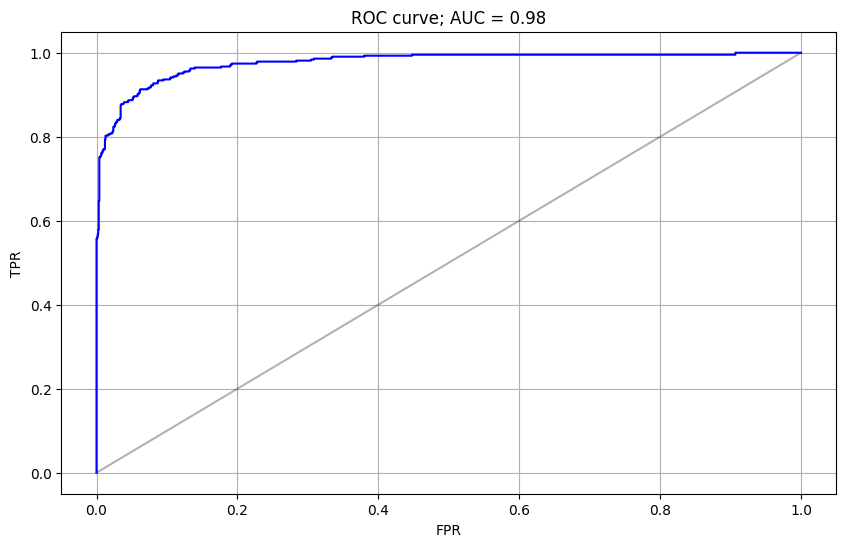

In [117]:
roc_curve = get_roc_curve(y_probs, y_test)
rock_auc = auc(*roc_curve)
plot_curve(*roc_curve, 'FPR', 'TPR', f'ROC curve; AUC = {rock_auc:.2f}')